Based on https://www.dataquest.io/blog/kaggle-getting-started/

## Step 1: Acquire the data and create our environment


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

import data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

size of the data

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

('Train data shape:', (1460, 81))
('Test data shape:', (1459, 80))


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Step 2: Explore the data and engineer Features


### Describe the target variable

In [6]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

check skewness (asymetry in the distribution) (log-transform the target variable when it is skewed,to improve the linearity of the data)
Importantly, the predictions generated by the final model will also be log-transformed, so we’ll need to convert these predictions back to their original form later.


('Skew is:', 1.8828757597682129)


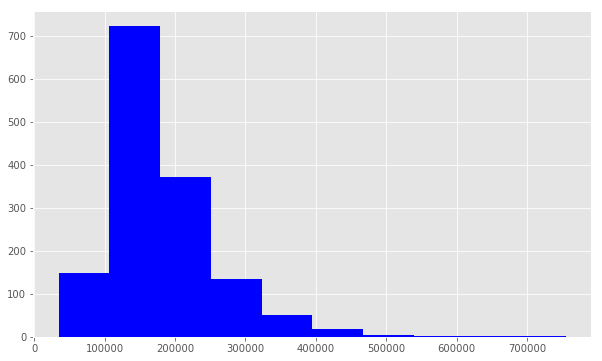

In [7]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

Notice that the distribution has a longer tail on the right. The distribution is positively skewed.

transform train.SalePric with log()
A value closer to 0 means that we have improved the skewness of the data.



('Skew is:', 0.12133506220520406)


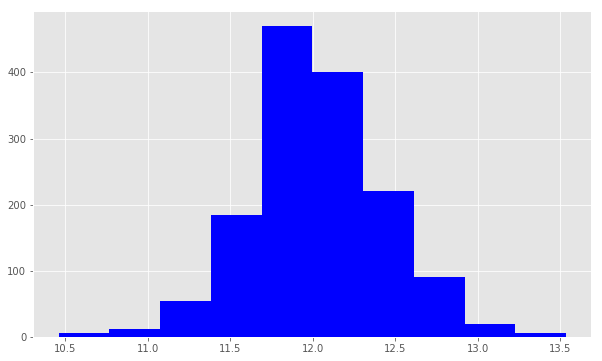

In [8]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

### Features (Numeric and Factors)

.select_dtypes() method will return a subset of columns matching the specified data types.

#### Numeric features

In [10]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

The DataFrame.corr() method displays the correlation (or relationship) between the columns. We’ll examine the correlations between the features and the target.


In [11]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

(SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64, '\n')
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


##### OverallQuality deep dive - Discrete feature

In [12]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [14]:
quality_pivot = train.pivot_table(index='OverallQual',values='SalePrice', aggfunc=np.median)

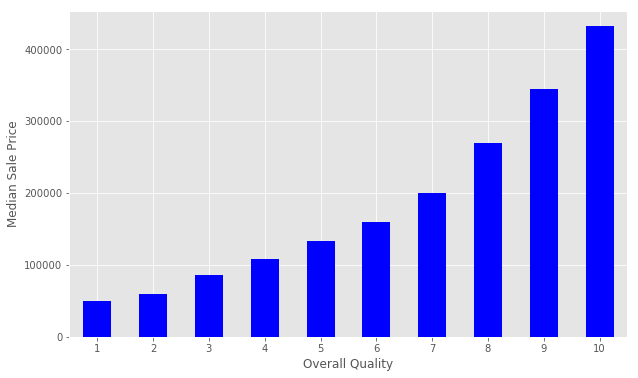

In [16]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

##### Continous feature

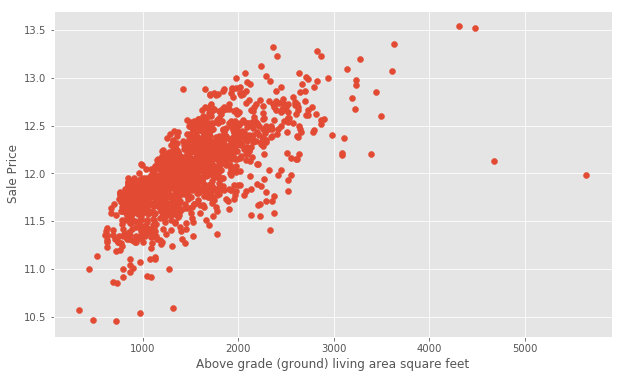

In [17]:
plt.scatter(x=train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

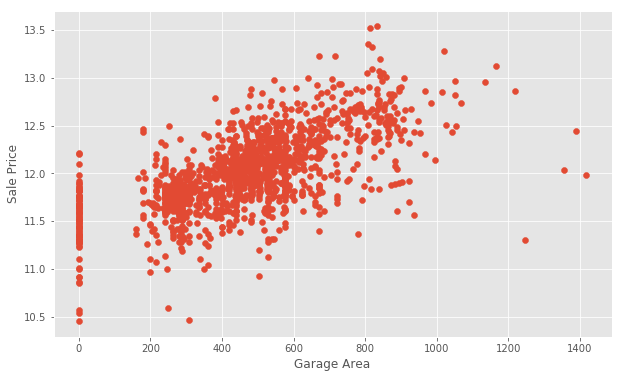

In [18]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

Outliers with Garage with 0 sqr meter -> remove exemples

In [21]:
train = train[train['GarageArea'] < 1200]

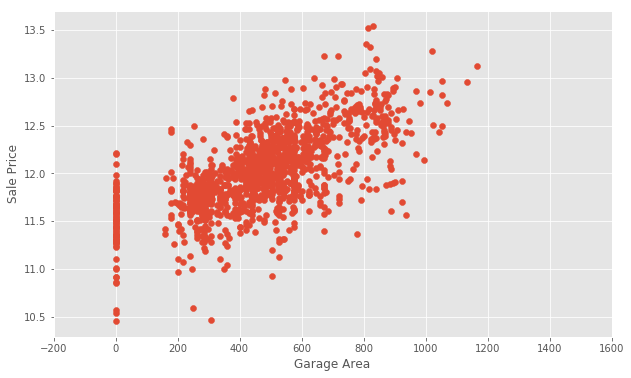

In [22]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

#### Handling Null Values

We will create a DataFrame to view the top null columns. 
Chaining together the train.isnull().sum() methods, we return a Series of the counts of the null values in each column.


In [23]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


Look at main missing value features in the documentation

The documentation can help us understand the missing values. 
In the case of PoolQC, the column refers to Pool Quality. 
Pool quality is NaN when PoolArea is 0, or there is no pool. 
We can find a similar relationship between many of the Garage-related columns.

Let’s take a look at one of the other columns, MiscFeature. 
We’ll use the Series.unique() method to return a list of the unique values.

In [24]:
print ("Unique values are:", train.MiscFeature.unique())

('Unique values are:', array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object))


#### Wrangling the non-numeric Features

In [25]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


For many of these features, we might want to use one-hot encoding to make use of the information for modeling.
One-hot encoding is a technique which will transform categorical data into numbers so the model can understand whether or not a particular observation falls into one category or another.


##### Transforming and engineering features

Attention: apply the same feature engineering as the train to the test set

In [26]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

(Pave    1450
Grvl       5
Name: Street, dtype: int64, '\n')


In [27]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [28]:
print ('Encoded: \n') 
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


###### Other feature engineering

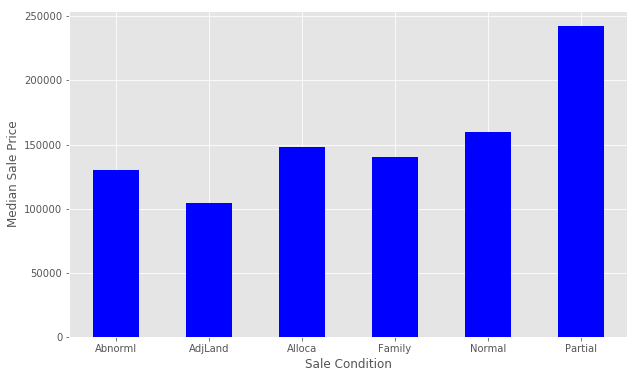

In [29]:
condition_pivot = train.pivot_table(index='SaleCondition',
                                    values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

Notice that Partial has a significantly higher Median Sale Price than the others.
We will encode this as a new feature.
We select all of the houses where SaleCondition is equal to Patrial and assign the value 1, otherwise assign 0.

In [31]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

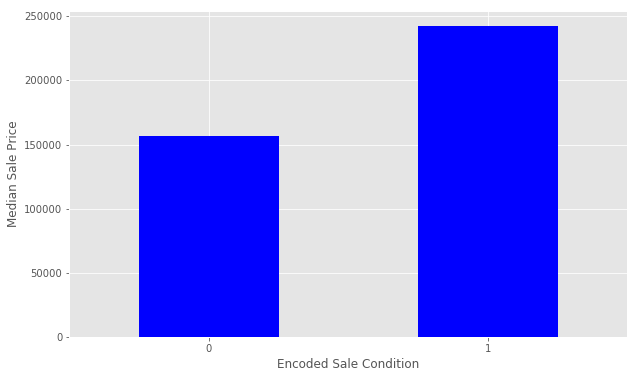

In [32]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

##### Missing Value -> Interpolation

We’ll the missing values with an average value and then assign the results to data. 
This is a method of interpolation. The DataFrame.interpolate() method makes this simple.
This is a quick and simple method of dealing with missing values, and might not lead to the best performance of the model on new data. 
Handling missing values is an important part of the modeling process, where creativity and insight can make a big difference. This is another area where you can extend on this tutorial.

In [33]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna() 

In [34]:
sum(data.isnull().sum() != 0)

0

## Step 3 : Build a linear model